In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [2]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Data>1. Data</a><br>
    <a href=#FoodFeedOtherAcross>2. Across Farm Sizes</a><br>
    <a href=#FoodFeedOtherWithin>3. Within Farm Sizes</a><br>
    <a href=#GlobalEstimates>3. Global Estimates</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    <a href=#LeftOff>Left Off Here</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>General Results</h1>


This page overviews our general results:

- The main findings are that in our sample of {{number_countries}} countries, farms < 2 ha produce {{under_two}}% of the total food supply (global estimate of between 8.8% to 23.2% via jacknife sampling).<br><br>

- The most food producing farm size class were farms between 100 to 200 ha, which produced {{onehund_twohund}}% of the total food supply inour sample and a global estimate between 14.8% to 29.4% via the jacknife sample. The largest differences (in terms of effect size) in the amount of food produced were between the very large farm and the smallest farm categories in terms of how much food each produced.<br><br> 

- The farm size contributing to the largest amount of food waste (post-harvest loss, not consumer based food waste) are farms between 50-100 ha.<br><br>

- This study also measures what percentage of each farm size class's crop producion goes towards food, feed, processing, seed, waste, or other. The farm size category with the largest percentage of food produced compared to other cateogories within thier farm size group, are from 100 to 1000 ha, where 70% of thier crop production goes towards food.<br><br>

- {{under_two_food}}% of crop production on farms < 2 ha goes towards food, while {{under_two_feed}}% goes towards feed and {{under_two_waste}}% is lost post-harvest. The remainder either goes towards other, processing, or seed.<br><br>

This page overviews our general results:

- The main findings are that in our sample of 54 countries, farms < 2 ha produce 16.3% of the total food supply (global estimate of between 8.8% to 23.2% via jacknife sampling).<br><br>

- The most food producing farm size class were farms between 100 to 200 ha, which produced 23.1% of the total food supply inour sample and a global estimate between 14.8% to 29.4% via the jacknife sample. The largest differences (in terms of effect size) in the amount of food produced were between the very large farm and the smallest farm categories in terms of how much food each produced.<br><br>

- The farm size contributing to the largest amount of food waste (post-harvest loss, not consumer based food waste) are farms between 50-100 ha.<br><br>

- This study also measures what percentage of each farm size class's crop producion goes towards food, feed, processing, seed, waste, or other. The farm size category with the largest percentage of food produced compared to other cateogories within thier farm size group, are from 100 to 1000 ha, where 70% of thier crop production goes towards food.<br><br>

- 56% of crop production on farms < 2 ha goes towards food, while 16% goes towards feed and 4% is lost post-harvest. The remainder either goes towards other, processing, or seed.


In [17]:
import warnings
warnings.filterwarnings('ignore')
import subprocess
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
import copy
from collections import OrderedDict
from pivottablejs import pivot_ui  # may have to use: python setup.py install --user
import scipy.stats as st
import statsmodels.stats.api as sms
from scipy.stats import linregress
import matplotlib.patches as patches
from sklearn import linear_model
# import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [18]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 1, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])
    
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    return data

In [19]:
def clean_data(data):

    global variables
    variables = OrderedDict([('Farm_Sizes', 'Farm_Sizes'),
                             ('production_Food_kcal', 'Food'),
                             ('production_Feed_kcal', 'Feed'),
                             ('production_Seed_kcal', 'Seed'),
                             ('production_Waste_kcal', 'Waste'),
                             ('production_Processing_kcal', 'Processing'),
                             ('production_Other_kcal', 'Other')])

    data = data.loc[:, variables.keys()]
    data.columns = variables.values()

    return data

In [20]:
def piv(data, func=np.nansum):

    pivot = pd.pivot_table(data,
                           index=['Farm_Sizes'],
                           values=variables.values()[1:],
                           aggfunc=func)

    return pivot

In [21]:
def perc(data, how='within'):

    if how is 'within':

        pivot = piv(data)
        pivot = pivot.transpose()

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()


    elif how is 'cumsum':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        pivot = pivot.cumsum(axis=0)

        return pivot


    elif how is 'across':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()

    else:

        print 'Require how argument'

In [22]:
PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
data_orig = read_data_init(PATH)
df = clean_data(data_orig)

In [23]:
df_within = perc(df, how='within')
df_across = perc(df, how='across')
df_cumsum = perc(df, how='cumsum')
df_across_prod = pd.DataFrame(df_across.mean(), columns=['All']).reset_index()
df_raw = piv(df)

In [24]:
tmp1 = df_within.copy()
tmp1['Type'] = 'Within'

tmp2 = df_across.copy()
tmp2 = tmp2.transpose()
tmp2['Type'] = 'Across'

tmp3 = df_cumsum.copy()
tmp3['Type'] = 'Cumsum'

tmp4 = df_raw.copy()
tmp4['Type'] = 'Raw'

tmp5 = df_across_prod.copy()
tmp5['Type'] = 'All'

tmp = pd.concat([tmp1, tmp2, tmp3, tmp4])
tmp = tmp.reset_index()
# tmp = pd.merge(tmp, tmp5, on=['Farm_Sizes', 'Type'], how='outer')
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace('(', '')
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace(']', '')

In [25]:
under_two = round(100 * df_cumsum.iloc[1,1], 1)
under_fifty = round(100 * df_cumsum.iloc[5,1], 1)
onehund_twohund = round(100 * (df_across.iloc[1, 7]), 1)

one_food = round(100 * df_within.iloc[0,1], 1)
one_waste = round(100 * df_within.iloc[0,5], 1)
two_food = round(100 * df_within.iloc[1,1], 1)
two_waste = round(100 * df_within.iloc[1,5], 1)
one_feed =  round(100 * df_within.iloc[0,0], 1)
two_feed =  round(100 * df_within.iloc[1,0], 1)

tmp_txt = data_orig.query("production_Food == production_Food")
number_countries = number_countries = len(tmp_txt.NAME_0.unique())
number_records = len(tmp_txt)
under_two_food = int(round((one_food + two_food) / 2, 0))
under_two_waste = int(round((one_waste + two_waste) / 2, 0))
under_two_feed = int(round((one_feed + two_feed) / 2, 0))

<a name="Data"></a>
<h2>Data</h2><br>

For an overview of the data, see the [data coverage notebook](https://vinnyricciardi.github.io/farmsize_site/Html/Data_Coverage).<br><br>
Click the table to interactively explore the data. Use 'type' to change whether you are looking at the percentage of crop produced for each category 'within' a farm size group, 'across' groups, via a 'cumulative' percentage across groups, or raw kcal produced. Use the dropdown labeled 'Food' to recalculate based on another production category. 

In [26]:
# pivot_ui(tmp, 
#          rows=['Farm_Sizes'], 
#          cols=['Type'], 
#          aggregatorName='Sum', 
#          vals=['Food'],
#          rendererName='Col Heatmap', 
#          colOrder= "value_a_to_z")
# tmp.to_csv('/Users/Vinny_Ricciardi/Downloads/pivot_test.csv')

# Enable for pivot table interactivitity within this Jupyter notebook
# Here's a nice example of how to change the html output file for prettier output when in html: 
# https://pivottable.js.org/examples/montreal_2014.html

In [27]:
gen_path = '/Users/Vinny_Ricciardi/Documents/Scripts/Python/Projects/FarmSize_Global/virtualenvironment/app_/JupyterSite/'
html_path = gen_path + 'Notebooks/pivottablejs.html'
img_path = gen_path + 'Html/pivot_pic.png'

subprocess.call("wkhtmltoimage {} {}".format(html_path, img_path), shell=True);

In [28]:
%%html
<a href="https://vinnyricciardi.github.io/farmsize_site/Html/pivottablejs" 
rel="some text">
<img src=https://vinnyricciardi.github.io/farmsize_site/Html/pivot_pic.png 
    alt="Drawing" style="width: 700px;"/>

<a name="FoodFeedOtherAcross"></a>
<h2>Food Feed Other by Farm Size</h2><br>

In [29]:
t = round(100 * df_across.iloc[1,-2], 1)

This plot shows the percentage that each farm size contributes to each category (e.g., food, feed, other, etc.) For example, farms between 500 to 1000 ha produce {{round(100 * df_across.iloc[1,-2], 1)}}% of the total food supply in our sample.

In [30]:
def plot_stacked_bar(data, how='within', fig_=True, ax=None):

    txt1 = ['Feed', 'Food', 'Other', 'Processing', 'Seed', 'Waste']
    txt2 = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
            '20 to 50', '50 to 100', '100 to 200', '200 to 500',
            '500 to 1000', '> 1000']
    txt3 = ['< 1', '2 to 5', '10 to 20', '50 to 100', '200 to 500', '> 1000']

    if how is 'within':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt2)
        cmap = cm.get_cmap('Set3')
        kind = 'bar'

    elif how is 'across':

        legend_txts = copy.copy(txt2)
        labels_txts = copy.copy(txt1)
        cmap = cm.get_cmap('YlGnBu')
        kind = 'bar'

    elif how is 'cumsum':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt3)
        cmap = cm.get_cmap('Set3')
        kind = 'area'
    
    else:
        pass
    
    if fig_ is True:
        
        fig = plt.figure(figsize=[10, 5], facecolor='white')
        ax = fig.add_subplot(111)
    
    else:
        pass

    data.plot(kind=kind,
              stacked=True,
              cmap=cmap,
              alpha=0.9,
              linewidth=0,
              grid=False,
              ax=ax)
    
    # Axis main
    ax.set_axis_bgcolor("#d6d7e5")
    ax.set_clip_on(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Legend
    legend_txts_r = copy.deepcopy(legend_txts)
    legend_txts_r.reverse()
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1],
                       loc='center left',
                       frameon=1,
                       bbox_to_anchor=(1, 0.5))

    for i in xrange(len(legend_txts_r)):
        legend.get_texts()[i].set_text(legend_txts_r[i])

    frame = legend.get_frame()
    frame.set_color('white')

    # Axis particulars
    ax.set_xticklabels(labels_txts)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

    if how is 'within':
        ax.set_xlabel('Farm Sizes (ha)')
        ax.set_ylabel('Percentage\n')
        ax.set_ylim([0, 1])
        ax.set_title('Type of production per farm size\n', fontsize=12)

    elif how is 'across':
        ax.set_xlabel('Category')
        ax.set_ylabel('Percentage\n')
        ax.set_ylim([0, 1])
        ax.set_title('Type of production across farm size\n', fontsize=12)
        
    elif how is 'cumsum':
        ax.set_xlabel('Farm Sizes (ha)')
        ax.set_ylabel('Percentage\n')
        ax.set_title('Type of production per farm size: Cumulative\n', fontsize=12)

    if fig_ is True:
        return plt.show()

    else:
        return ax


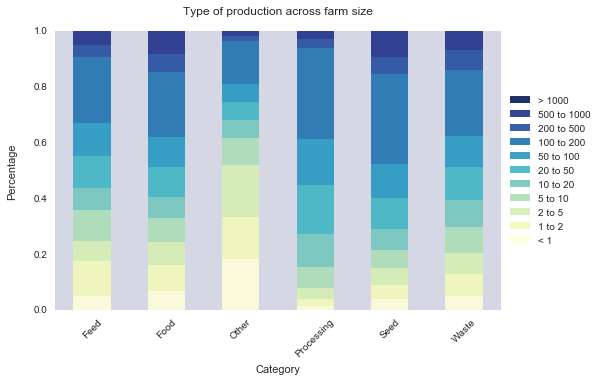

In [31]:
plot_stacked_bar(df_across, how='across', fig_=True)

This plot also shows the percentage that each farm size contributes to each category but in cumulative percentages. For example, farms under 2 ha produce {{under_two}}% of the total food supply in our sample and farms 50 ha and under produce {{under_fifty}}% of the total food supply in our sample. Again, here is a [link](https://vinnyricciardi.github.io/farmsize_site/Html/pivottablejs) to an interactive pivot table so you can explore the data in more detail.

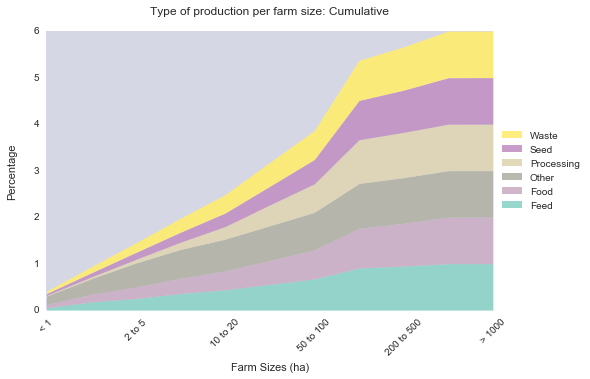

In [32]:
plot_stacked_bar(df_cumsum, how='cumsum', fig_=True)

In [33]:
def factor_plot(data, id_var='Farm_Sizes'):
    
    data = pd.melt(data, id_vars='Farm_Sizes')
    data = data.loc[data['value'] > 0.5] 
    data['log'] = np.log(data['value'])
    
    fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                '(500, 1000]', '(1000, 100000]']
    
    if id_var is 'Farm_Sizes':
        
        col = 'variable'
        x = 'Farm_Sizes'
        y = 'log'
        order = fs_order

    else:
        
        data = data.sort('Farm_Sizes')
        data['Farm_Sizes'] = pd.Categorical(data['Farm_Sizes'], fs_order)
        data = data.sort('Farm_Sizes')
        col = 'Farm_Sizes'
        x = 'variable'
        y = 'log'
        order = None

    g = sns.factorplot(x=x, y=y,
                       col=col, 
                       data=data,
                       kind='box',
                       col_wrap=4,
                       color='#55a868',
                       fliersize=1,
                       aspect = 1,
                       order=order)

    g.fig.subplots_adjust(wspace=0.2, hspace=0.3)

    titles = data.variable.unique()
    
    fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
              '20 to 50', '50 to 100', '100 to 200', '200 to 500',
              '500 to 1000', '> 1000']
    
    if id_var is 'Farm_Sizes':
        
        for ax, title in zip(g.axes.flat, titles):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(fs_txt)
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nFarm Sizes (ha)')
        
    else:
        
        for ax, title in zip(g.axes.flat, fs_txt):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nPoduction Category')

In order to better understand whether there are differences between the farm size groups, these boxplots show the total amount of crops produced (in logged kcal for standardization). Across all production categories (e.g., food, feed, other, etc.) there are no visual differences in the means and confidence intervals. But, there are many of outliers in each plot that indicate high variance.

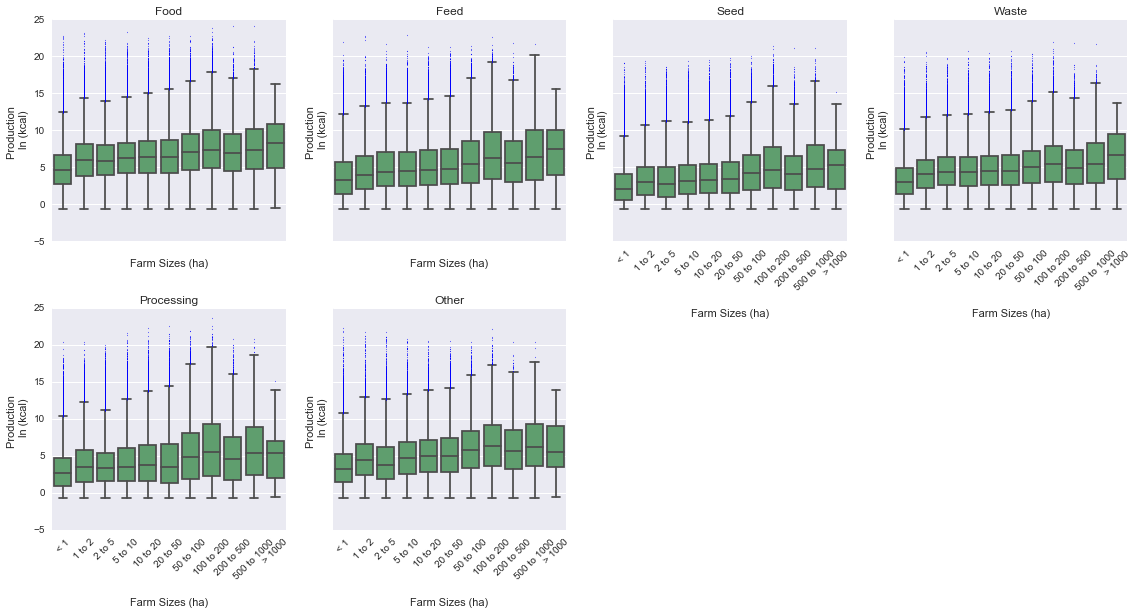

In [34]:
factor_plot(df, id_var='Farm_Sizes')

Since many of the plots have large variance and skewness, here are density plots comparing farm size classes per each category. We can see that the largest farm size group has different distributions from the remaining groups.

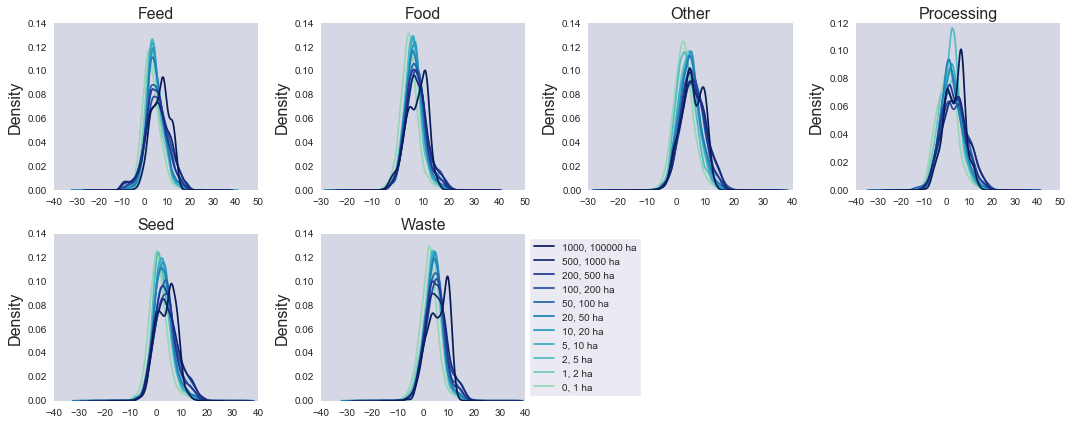

In [35]:
colors_ = ['#97d6b9',
           '#73c8bd',
           '#52bcc2',
           '#37acc3',
           '#2498c1',
           '#1f80b8',
           '#2165ab',
           '#234da0',
           '#253795',
           '#172978',
           '#081d58'] 

tmp = df.copy()
tmp = pd.melt(tmp, id_vars='Farm_Sizes')
tmp = tmp.dropna()
cols = np.sort(tmp['variable'].unique())
fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
      '(10, 20]', '(20, 50]', '(50, 100]', 
      '(100, 200]', '(200, 500]', '(500, 1000]', 
      '(1000, 100000]']

fig = plt.figure(figsize=[15, 6])

for j in xrange(len(cols)):
    
    ax = fig.add_subplot(2, 4, j+1)
    ax.set_axis_bgcolor("#d6d7e5")
    ax.grid(alpha=0.0)

    tmp1 = tmp.loc[tmp['variable'] == cols[j]]

    for i in xrange(len(fs)):

        tmp2 = tmp1.loc[tmp1['Farm_Sizes'] == fs[i]]
        np.log(tmp2['value']).plot(kind='kde', 
                                   label=fs[i][1:-1] + ' ha',
                                   color=colors_[i],
                                   ax=ax)
        
    ax.set_title(cols[j], fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    
legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))
# frame = legend.get_frame()
# frame.set_color('#d6d7e5')

plt.tight_layout()
plt.show()

Since our sample is very large ({{number_countries}} countries which comprise of {{number_records}} total records due to subnational units and crop types) we cannot use p-values to determine significance between the amount of production by varying farm sizes.<br><br>
To circumvent the large dataset issue, the effect size was used to determine differences between farm sizes rather than statistical significance. Cohen's d was calculated via taking the (mean of farmsize 1 - mean of farmsize 2) / (standard deviation of farmsize 1) then taking the absolute value. The relative significance was calculated by thresholds according to [Sullivan and Feinn 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444174/).

Where the Cohen d's effect size values correspond to percent non-overlapping observations, as in:


| **Relative Size** | **Effect Size**| **Percentile**| **% of Non-overlap**|
|---------------	|:-------------:|:-----------:	|:-------------------:	|
|               	|      0      	|     50    	|         0         	|
| Small         	|     0.2     	|     58    	|         15        	|
| Medium        	|     0.5     	|     69    	|         33        	|
| Large         	|     0.8     	|     79    	|         47        	|
|               	|     1.0     	|     84    	|         55        	|
|               	|     1.5     	|     93    	|         71        	|
|               	|     2.0     	|     97    	|         81        	|

In [71]:
def cohens_d(data1, data2, how='within'):

    cols = data1.columns
    check = []
    
    for i in xrange(0, len(cols)):
        
        for j in xrange(1, len(cols)):
            
            col_name = str(cols[i]) + '_' + str(cols[j])
            col_name_r = str(cols[j]) + '_' + str(cols[i])

            if col_name in check:
                
                pass

            elif cols[i] is cols[j]:
                
                pass

            else:
                
                pass
                
            data1[col_name] = ((data1[cols[i]] - data1[cols[j]]) / data2[cols[i]]).abs()
            check.append(col_name)
            check.append(col_name_r)


    data = data1.iloc[:, len(cols):]

    data = data.reset_index()

    if how is 'across':
        
        data = pd.melt(data, id_vars='index', value_name='cohens_d')
        
    elif how is 'within':
        
        data = data.transpose()
        data = data.reset_index()
        data = data.iloc[:, :-1]
        cols = list(data1.transpose().columns[:-1])
        cols.insert(0, 'Category')
        data.columns = cols
        data = data.iloc[1:, :]
        data = pd.melt(data, id_vars='Category', value_name='cohens_d')

    else:
        print 'Check how arg'
        
    data['cohens_d_level'] = np.where(data['cohens_d'] <= 0.2, 'small',
                                      np.where(data['cohens_d'] >= 0.8, 'large',
                                               'medium'))

    return data

In [37]:
# def cohens_interp(func=np.mean, index='index'):
    
#     tmp = pd.pivot_table(out, 
#                          index=index, 
#                          columns='cohens_d_level', 
#                          values='cohens_d', 
#                          aggfunc=func)   
    
#     tmp = tmp.reset_index()
#     tmp = tmp.dropna()

#     try:
#         tmp = tmp.sort('large', ascending=False)
#         tmp.columns = ['Category', 'large d', 'medium d', 'small d']

#     except:
#         tmp = tmp.sort('medium', ascending=False)
#         tmp.columns = ['Farm Sizes', 'medium d', 'small d']
    
#     return tmp

Here are the biggest differences between farm size groups. As expected, there are large coefficients (effect size) between small and large farm classes. Note, the largest farm size class (> 1000 ha had minimal data points, which seemed to cause distributions were very different than the otehr classes. For now, this class was omitted in the below results).

In [69]:
def plot_cohensd_heatmap(data, ax=None):
    
    fs = ['1, 2',
          '2, 5',
          '5, 10',
          '10, 20',
          '20, 50',
          '50, 100',
          '100, 200',
          '200, 500',
          '500, 1000']
    
    cats = ['Food', 'Other', 'Processing', 'Seed', 'Waste']

    hm = data.copy()
    hm = hm.loc[:, ['fs1', 'fs2', 'Cohens d']]

    hm['fs1'] = hm['fs1'].str.replace('(', '')
    hm['fs1'] = hm['fs1'].str.replace(')', '')
    hm['fs2'] = hm['fs2'].str.replace('(', '')
    hm['fs2'] = hm['fs2'].str.replace(')', '')
    hm = hm.dropna()
    hm['Cohens d'] = hm['Cohens d'].astype(float)
    
    hm = pd.pivot_table(hm, index=['fs1'], columns=['fs2'], values='Cohens d', fill_value=0., aggfunc=np.nanmean)

    try:
        
        hm = hm.loc[:, fs]
        hm = hm.reset_index()
        hm['fs1'] = pd.Categorical(hm['fs1'], fs)
        
    except:
        
        hm = hm.loc[:, cats]
        hm = hm.reset_index()
        hm['fs1'] = pd.Categorical(hm['fs1'], cats)

    hm = hm.sort_values('fs1')
    hm = hm.set_index('fs1')
    hm = hm.iloc[1:, :]
  
    sns.heatmap(hm, ax=ax);
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45);
    ax.set(xlabel='', ylabel='');

    
def plot_cohensd_barplot(data, ax=None, how='across'):
    
    fs = ['(1, 2)',
          '(2, 5)',
          '(5, 10)',
          '(10, 20)',
          '(20, 50)',
          '(50, 100)',
          '(100, 200)',
          '(200, 500)',
          '(500, 1000)']
    
    if how is 'across':

        t = pd.pivot_table(data, index=['Category'], values='Cohens d', aggfunc=np.sum)
        t = t.reset_index()
        t = t.sort_values('Cohens d', ascending=False)
        order = t['Category'].unique()
        sns.barplot(data['Category'], data['Cohens d'], order=order, color='#94D3CA', ax=ax);

    else:
        
        t = pd.pivot_table(data, index=['Farm_Sizes'], values='Cohens d', aggfunc=np.sum)
        t = t.reset_index()
        t = t.sort_values('Cohens d', ascending=False)
        order = t['Farm_Sizes'].unique()
        sns.barplot(data['Farm_Sizes'], data['Cohens d'], order=order, color='#94D3CA', ax=ax);
        
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45);
    ax.set(xlabel='', ylabel='Cohens d');

    
def plot_cohens_all(data, how='across'):

    fig = plt.figure(figsize=[15,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plot_cohensd_heatmap(data, ax=ax1);
    plot_cohensd_barplot(data, how=how, ax=ax2);
    ax1.set_title("Pairwise effect size\n", fontsize=14);
    ax2.set_title("Mean effect size per grouping\n", fontsize=14);
    
    return plt.show()
def cohens_full_func(data, how='across'):

    data = data.loc[data['Farm_Sizes'] != '(1000, 100000]']
    data['Farm_Sizes'] = data['Farm_Sizes'].astype(str)

    means = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanmean)
    sds = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanstd)

    if how is 'across':
        
        tmp = cohens_d(means, sds, how=how)
        tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace(']', ')')
        tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace('_', ' and ')
        tmp.columns = ['Category', 'Farm sizes compared', 'Cohens d', 'Relative effect size']
        tmp = tmp.sort('Cohens d', ascending=False)
        t = tmp['Farm sizes compared'].str.split(' and ', expand=True)
        t.columns = ['fs1', 'fs2']
        tmp = pd.concat([tmp, t], axis=1) 

    else:
        
        means = means.transpose()
        sds = sds.transpose()
        tmp = cohens_d(means, sds, how=how)
        tmp.columns = ['Category', 'Farm_Sizes', 'Cohens d', 'Relative effect size']
        tmp = tmp.sort('Cohens d', ascending=False)
        t = tmp['Category'].str.split('_', expand=True)
        t.columns = ['fs1', 'fs2']
        tmp = pd.concat([tmp, t], axis=1) 

    
    return plot_cohens_all(tmp, how=how)

On average, the largest effect size (differences) between farm sizes were in the seed and processing categories. The 100 to 200 ha class had the greatest differences between their contributions to each food, feed, other cateogry compared to other farm size classes contributions.

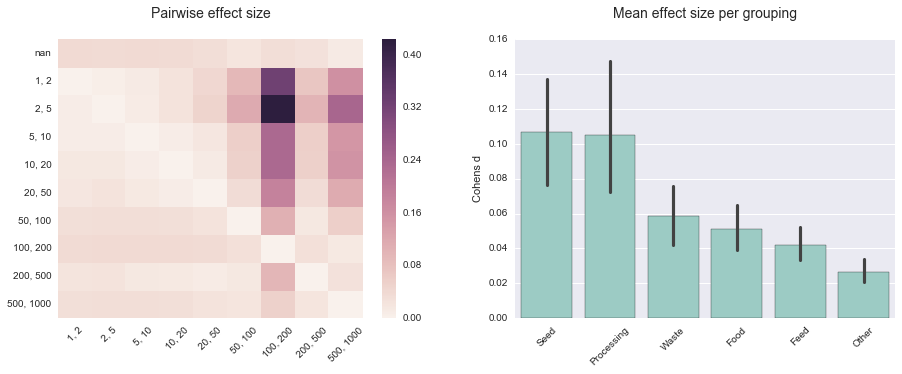

In [72]:
cohens_full_func(df, how='across')

<a name="FoodFeedOtherWithin"></a>
<h2>Food Feed Other within Farm Size Groups</h2><br>

This plot shows the percentage of Food, Feed, Seed, Waste, Processing, and Other for each farm size category. For example, {{one_food}} % of the crops produced for farms under 1 ha is food, while {{one_waste}}% of their crop production is waste.

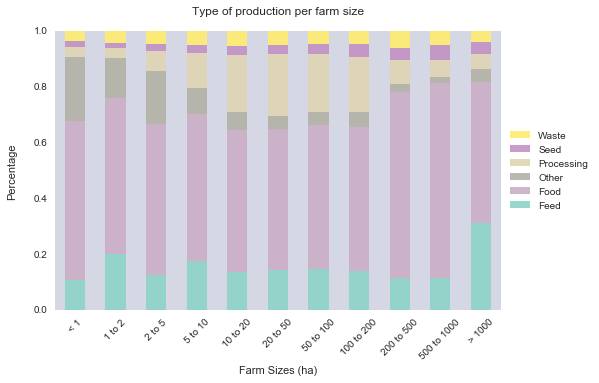

In [56]:
plot_stacked_bar(df_within, how='within', fig_=True)

In order to better understand whether there are differences within how a given farm size group allocates their crop production, these boxplots show the total amount of crops produced (in logged kcal for standardization). As in the previous analysis, across all farm size categories there are no visual differences in the means and confidence intervals. But, there are many of outliers in each plot that indicate high variance.

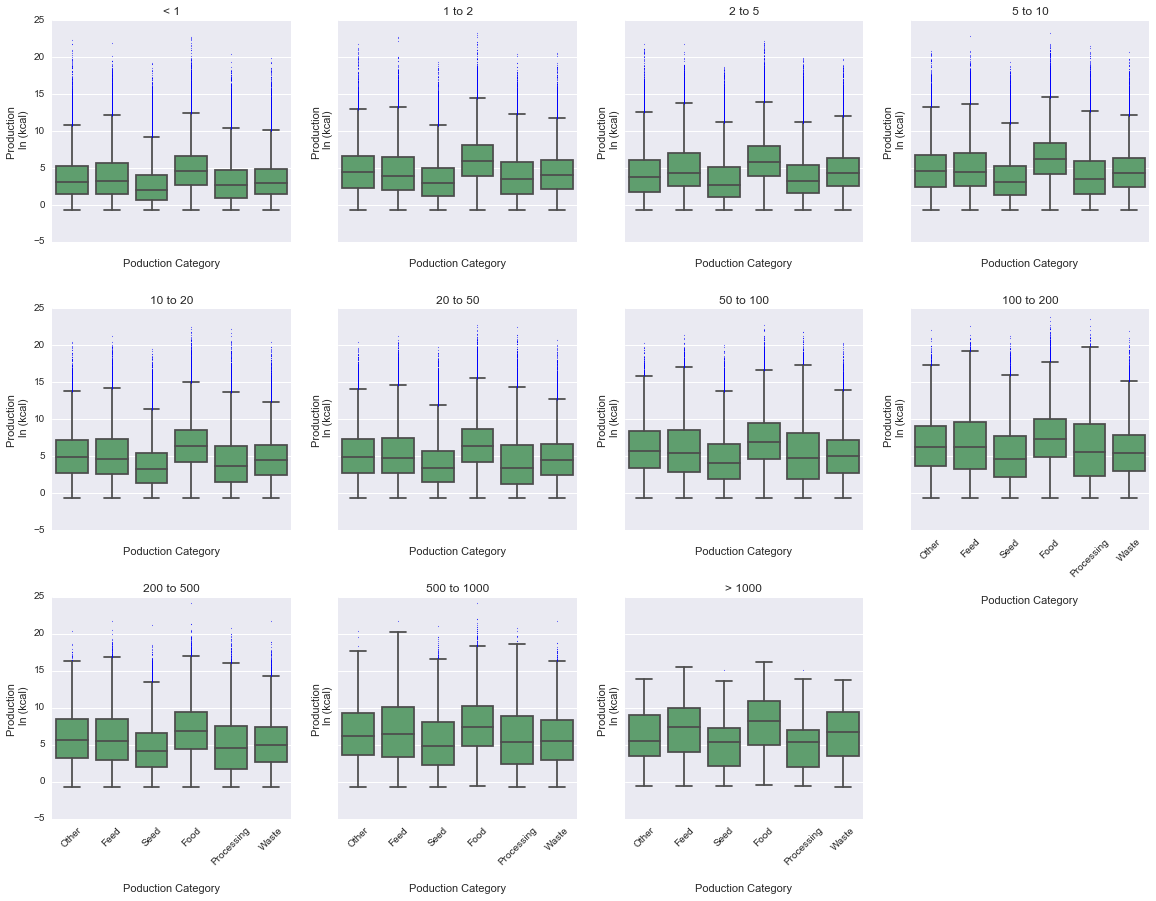

In [47]:
factor_plot(df, id_var='variable')

Since many of the plots have large variance and skewness, here are density plots comparing farm size classes per each category. We can see that the largest farm size group has different distributions from the remaining groups.

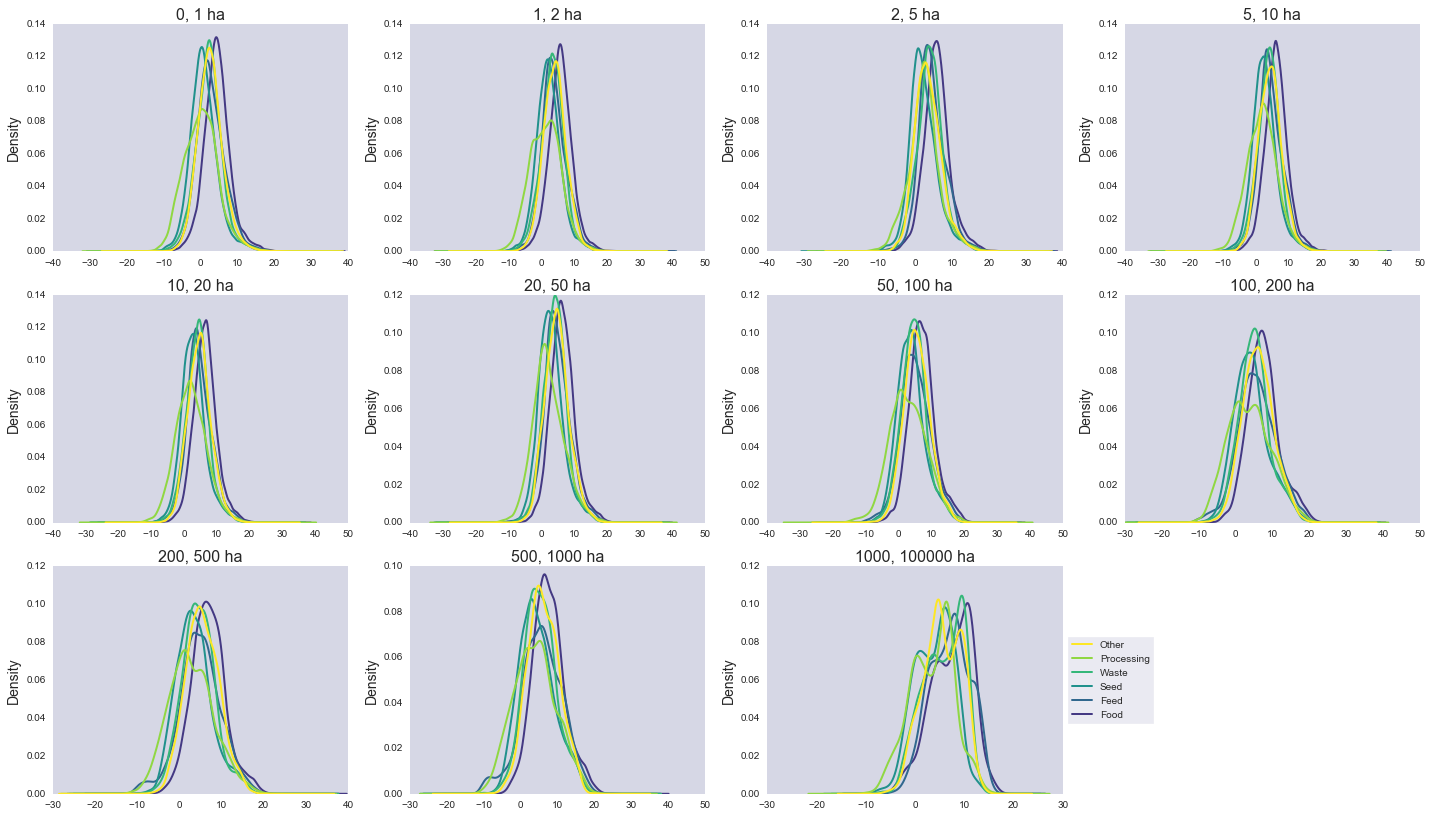

In [48]:
tmp = df.copy()
fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
      '(10, 20]', '(20, 50]', '(50, 100]', 
      '(100, 200]', '(200, 500]', '(500, 1000]', 
      '(1000, 100000]']

tmp = tmp.dropna()
cols = tmp.columns

cmap = cm.get_cmap('viridis', 7)    # Set3 and YlGnBu are used throughout
colors_ = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors_.append(colors.rgb2hex(rgb))


fig = plt.figure(figsize=[20,15])

for j in xrange(len(fs)):
    
    tmp1 = tmp.loc[tmp['Farm_Sizes'] == fs[j]]

    ax = fig.add_subplot(4, 4, j+1)
    ax.set_axis_bgcolor("#d6d7e5")
    ax.grid(alpha=0.0)

    for i in xrange(1, len(cols)):
        np.log(tmp1[cols[i]]).plot(kind='kde', 
                                   label=cols[i],
                                   color=colors_[i],
                                   linewidth=2,
                                   ax=ax)
    
    ax.set_title(fs[j][1:-1] + ' ha', fontsize=16)
    ax.set_ylabel('Density', fontsize=14)


legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

We calculated the effect size for the differences within each farm size group, but across production cateogries (e.g., food, feed, other).
There were only medium differences in effect size when looking at how each farm size group allocated their production. Most of the differences were between food and the other categories.

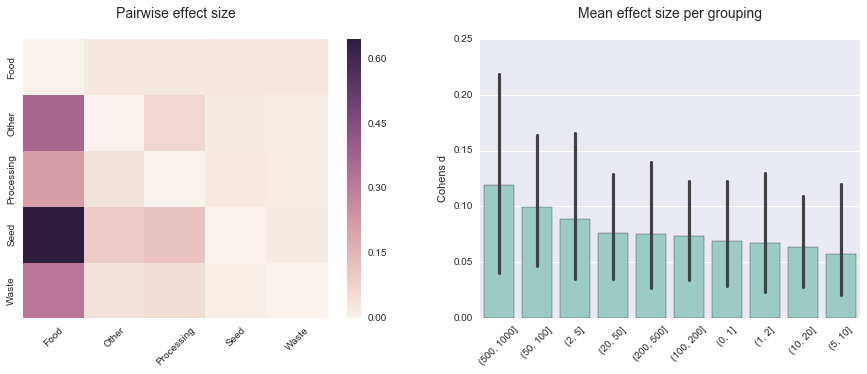

In [73]:
cohens_full_func(df, how='within')

<a name="GlobalEstimates"></a>
<h2>Global Estimates</h2><br>

To construct a global estimate based on our sample, we first resampled using the jacknife technique. We calculated the total food production while iteratively subsetting each country. Then we take the mean and confidence intervals for each farm size class. The jacknife resampling technique allows us to understand the error and bias in our results and construct confidence intervals around that bias.

In [83]:
def jacknife_prep(path, how='under2'):
    
    data = pd.read_csv(PATH, low_memory=False)
    
    if how is 'under2':

        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                    bins=[0, 2, 5, 10, 20, 50,
                                          100, 200, 500, 1000, 100000])
        
        fs_order = ['(0, 2]', '(2, 5]', '(5, 10]', '(10, 20]', 
                    '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']

        fs_txt = ['< 2', '2 to 5', '5 to 10', '10 to 20',
                  '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                  '500 to 1000', '> 1000']
        
    else:
        
        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                        bins=[0, 1, 2, 5, 10, 20, 50,
                                              100, 200, 500, 1000, 100000])
        
        fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                    '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']
                        
        fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
                  '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                  '500 to 1000', '> 1000']
        

    data = data.replace(0.0, np.nan)  # there were many zero values

    variables = ['NAME_0', 
                 'Crop', 
                 'Farm_Sizes', 
                 'production_Food_kcal']
    
    data = data.loc[:, variables]
    
    return data, fs_order, fs_txt

In [84]:
data, fs_order, fs_txt = jacknife_prep(PATH, how='under2')

In [85]:
def jacknife(data, variable='production_Food_kcal'):

    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
    data['ix'] = data['Farm_Sizes'].map(dictionary)

    out = pd.DataFrame(columns=['NAME_0', 'Farm_Sizes', 'Food'])

    for i in data.NAME_0.unique():

        tmp = data[data['NAME_0'] != i]

        pivot = pd.pivot_table(tmp, 
                               index=['Farm_Sizes', 'ix'],
                               values=variable, 
                               aggfunc=(np.nansum, np.nanstd, np.nanmean))

        f = pivot / np.nansum(pivot)
        f = f.reset_index()
        f['NAME_0'] = i
        out = pd.concat([out, f])
        out['ci_high'] = out['nansum'] + (1.96 * (out['nanstd'] / 10)) # Note, presently not using. based on highs, lows, as below
        out['ci_low'] = out['nansum'] - (1.96 * (out['nanstd'] / 10))

    return out

In [86]:
def jacknife_mean_CI(data):

    pivot = pd.pivot_table(data, 
                           index=['Farm_Sizes', 'ix'], 
                           values=['nansum'], 
                           aggfunc=(np.mean, np.max, np.min))
    
    pivot = pivot.reset_index()
    pivot.columns = pivot.columns.droplevel()
    pivot.columns = ['Farm_Sizes', 'ix', 'mean', 'ci_high', 'ci_low']
#     pivot.columns = ['Farm_Sizes', 'ix', 'ci_high', 'ci_low', 'mean']
    
    return pivot

In [87]:
df_jk = jacknife(data)
prods = jacknife_mean_CI(df_jk)

This chart shows the results of the jacknife sample. Each bar represents the range of food production by each farm size class.

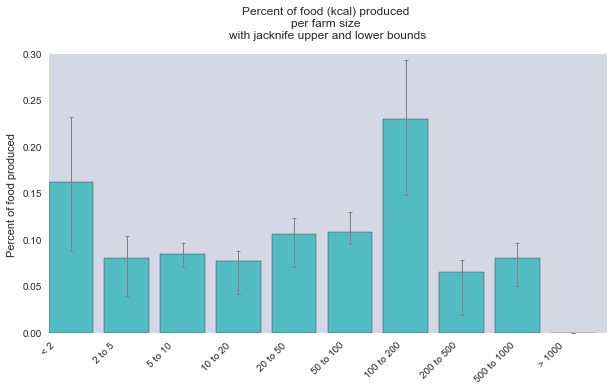

In [88]:
prods = prods.sort_values('ix')
yerr = np.c_[prods['mean'] - prods['ci_low'], prods['ci_high'] - prods['mean']].T

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)
ax.bar(range(len(prods['mean'])), prods['mean'], 
        yerr=yerr,
        color='#52bcc2',
        error_kw=dict(ecolor='gray', 
                      lw=1, 
                      capsize=2, 
                      capthick=1))

ax.set_xticklabels
ax.set_axis_bgcolor("#d6d7e5")
ax.grid(alpha=0.0)
ax.set_xticks(range(len(prods['mean'])))
ax.set_xticklabels(fs_txt, rotation=45)
ax.set_ylabel('Percent of food produced')
ax.set_title('Percent of food (kcal) produced '
             '\nper farm size '
             '\nwith jacknife upper and lower bounds\n')

plt.show()

Below shows the mean kcal of food produced when each country is omitted. The vertical black line is the mean kcal of food produced when no countries are omitted. If a country is to the left of the black line it lowers the global average.

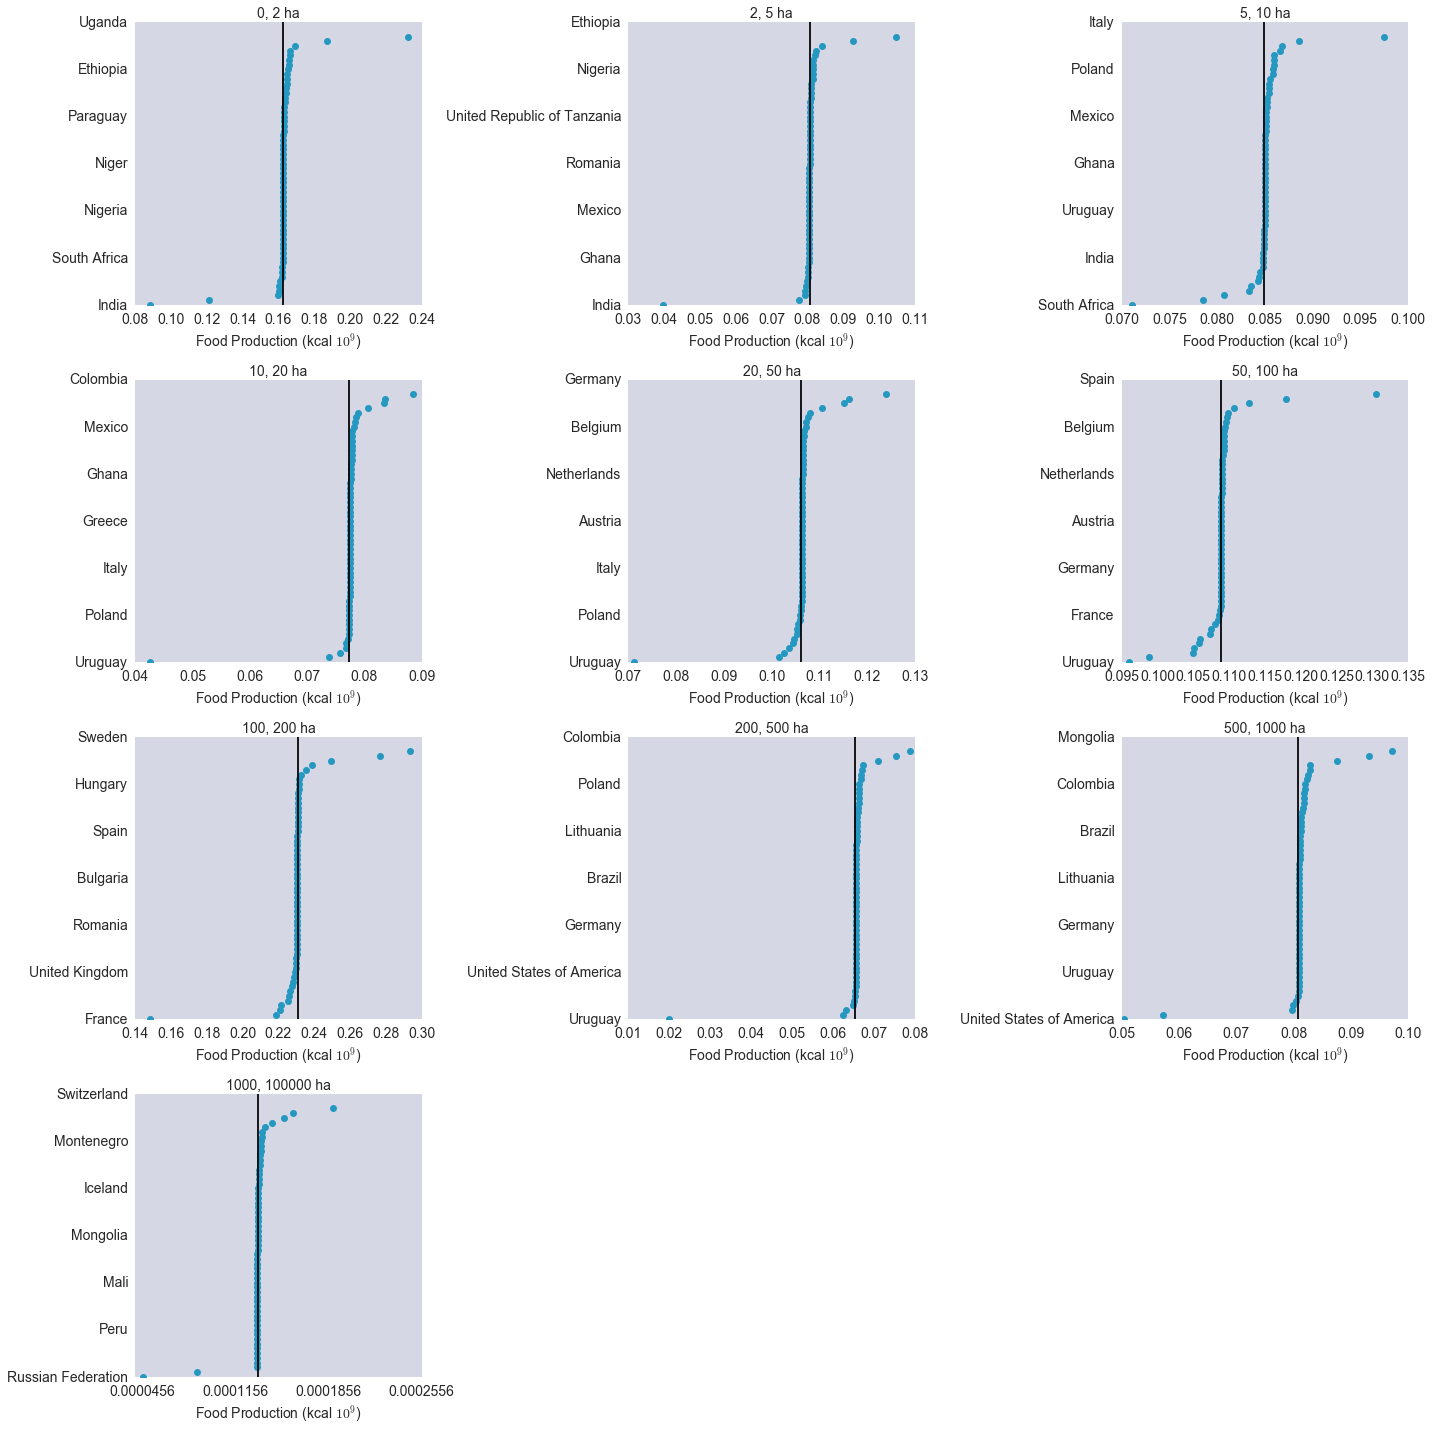

In [89]:
fig = plt.figure(figsize=[20,20])
# fs = prods['Farm_Sizes'].unique()
# fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
#       '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
#       '(500, 1000]', '(1000, 100000]']

# fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
#       '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
#       '(500, 1000]', '(1000, 100000]']

prods = df_jk.copy()
prods['ix_c'] = range(0, len(prods))

for i in xrange(len(fs_order)):

    ax = fig.add_subplot(4,3,i+1)
    
    tmp = prods[prods['Farm_Sizes'] == fs_order[i]]
    tmp = tmp.sort('nansum')
    tmp['ix_c'] = range(0, len(tmp['NAME_0']))
    ax.plot(tmp['nansum'], tmp['ix_c'], c='#2498c1', marker="o", linewidth=0, label='Prod')
    ax.axvline(x=tmp['nansum'].mean(), c='k')
#     ax.set_yticks(range(len(tmp.country.unique())))
    ax.set_yticklabels(tmp.NAME_0.unique(), fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel('Food Production (kcal $10^9$)', fontsize=14)
    title = fs_order[i][1:-1] + ' ha'
    ax.set_title(title, fontsize=14)
    ax.set_axis_bgcolor("#d6d7e5")
    ax.set_clip_on(False)
    ax.grid(alpha=0.0)

ax.set_xticks(np.arange(min(tmp['nansum']), max(tmp['nansum']) + 0.0001, .00007))

fig.tight_layout()
plt.show()

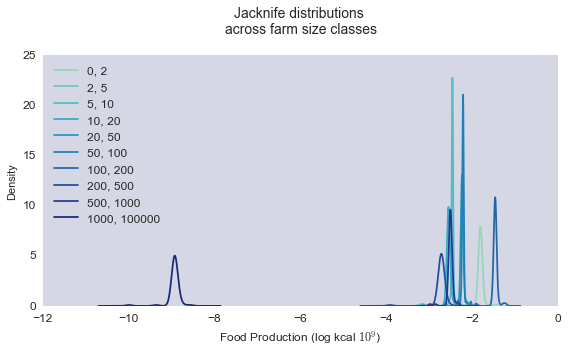

In [91]:
prods = df_jk.copy()

fig = plt.figure(figsize=[8, 5])
# fs = prods['Farm_Sizes'].unique()
# fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
#       '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
#       '(500, 1000]', '(1000, 100000]']

fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
      '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
      '(500, 1000]', '(1000, 100000]']

colors_ = ['#97d6b9',
          '#73c8bd',
          '#52bcc2',
          '#37acc3',
          '#2498c1',
          '#1f80b8',
          '#2165ab',
          '#234da0',
          '#253795',
          '#172978',
          '#081d58'] 

ax = fig.add_subplot(111)

for i in xrange(len(fs)): 
    tmp = prods[prods['Farm_Sizes'] == fs[i]]
    label = fs[i][1:-1]
    np.log(tmp['nansum']).plot(kind='kde', label=label, color=colors_[i], ax=ax)
    
legend = ax.legend(frameon=True, fontsize=12, loc='upper left')
frame = legend.get_frame()
frame.set_color('#d6d7e5')
ax.set_axis_bgcolor("#d6d7e5")
ax.grid(alpha=0.0)
ax.set_clip_on(False)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Food Production (log kcal $10^9$)', fontsize=12)
ax.set_title('Jacknife distributions \nacross farm size classes\n', fontsize=14)
fig.tight_layout()
plt.show()

<a name="LeftOff"></a>
<h3>Left Off</h3>

To Do:
- Can we make a simple mode to estimate production of food by farm size?
    - food produced (per farm size) = amount food produced (in kcal) + % operational holdings (per given farm size - note % area would be better, but China and other large countries do not have info available)<br><br>
    
Check out [this notebook](https://vinnyricciardi.github.io/farmsize_site/Html/Global_Estimate) for recent efforts.

- *Calculate effect sizes between each farm size group*
- *Need to calculate bootstraps estimates*
